<a href="https://colab.research.google.com/github/NganTran-0017/Gender-Detection/blob/main/Gender_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !>wget --recursive --no-parent --reject='index.html*' http://www.cslab.openu.ac.il/download/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/  --user adiencedb --password adience
#!pip install tensorflow 
#!pip install matplotlib
# !pip install opencv-python

In [1]:
import os
import pandas as pd
import glob
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import pickle

data_dir = '/Users/natal/Desktop/Data Quality Project/Gender-Detection/Data'
work_dir = '/Users/natal/Desktop/Data Quality Project/Gender-Detection/'

if not os.path.exists(work_dir):  os.makedirs(work_dir)
if not os.path.exists(data_dir):  os.makedirs(data_dir)

os.chdir(work_dir)
os.getcwd()

'C:\\Users\\natal\\Desktop\\Data Quality Project\\Gender-Detection'

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))
print(tf.config.list_logical_devices('GPU'))


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4444911376646810310
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9282586154569244372
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [3]:
# Create 2 virtual GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [ ]:
# Fetch data from Github

# unzip file
#!tar -zxvf 'Data\\adiencedb\\AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification\\aligned.tar.gz'

#!tar -zxvf Data/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/faces.tar.gz


In [4]:
# Read every
df_list = []
for file_name in glob("Data/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)
del df_list

print('Before dropping na:', df.shape)
df.dropna(inplace= True)
print('After dropping na:', df.shape)

Before dropping na: (32930, 12)
After dropping na: (31582, 12)


In [5]:
#get img path
df['image_path'] = df[['user_id', 'face_id', 'original_image']].apply(
    lambda x: '/'.join(['faces', f"{x[0]}", f"coarse_tilt_aligned_face.{x[1]}.{x[2]}"]), axis=1)

df['image_path'].values

array(['faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg',
       'faces/30601258@N03/coarse_tilt_aligned_face.2.10424815813_e94629b1ec_o.jpg',
       'faces/30601258@N03/coarse_tilt_aligned_face.1.10437979845_5985be4b26_o.jpg',
       ...,
       'faces/101515718@N03/coarse_tilt_aligned_face.2280.10587826073_6663f5b654_o.jpg',
       'faces/101515718@N03/coarse_tilt_aligned_face.2278.10587571495_a61785cd06_o.jpg',
       'faces/101515718@N03/coarse_tilt_aligned_face.2279.10587571495_a61785cd06_o.jpg'],
      dtype=object)

In [6]:
df.iloc[0]['image_path'], os.getcwd()

('faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg',
 'C:\\Users\\natal\\Desktop\\Data Quality Project\\Gender-Detection')

In [7]:
from PIL import Image
im = Image.open(df.iloc[0]['image_path']) 
im.show()


In [8]:
# Encode gender into binary
data = df[['image_path', 'gender']]
data['gender'] = data['gender'].apply(lambda x : 1 if x == 'm' else 0).astype(np.float32)
data

X = data[['image_path']].values 
y = data[['gender']].values 
X

C:\Users\natal\AppData\Local\Temp/ipykernel_16600/3760253394.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gender'] = data['gender'].apply(lambda x : 1 if x == 'm' else 0).astype(np.float32)


array([['faces/30601258@N03/coarse_tilt_aligned_face.1.10399646885_67c7d20df9_o.jpg'],
       ['faces/30601258@N03/coarse_tilt_aligned_face.2.10424815813_e94629b1ec_o.jpg'],
       ['faces/30601258@N03/coarse_tilt_aligned_face.1.10437979845_5985be4b26_o.jpg'],
       ...,
       ['faces/101515718@N03/coarse_tilt_aligned_face.2280.10587826073_6663f5b654_o.jpg'],
       ['faces/101515718@N03/coarse_tilt_aligned_face.2278.10587571495_a61785cd06_o.jpg'],
       ['faces/101515718@N03/coarse_tilt_aligned_face.2279.10587571495_a61785cd06_o.jpg']],
      dtype=object)

# **Visualizing images**

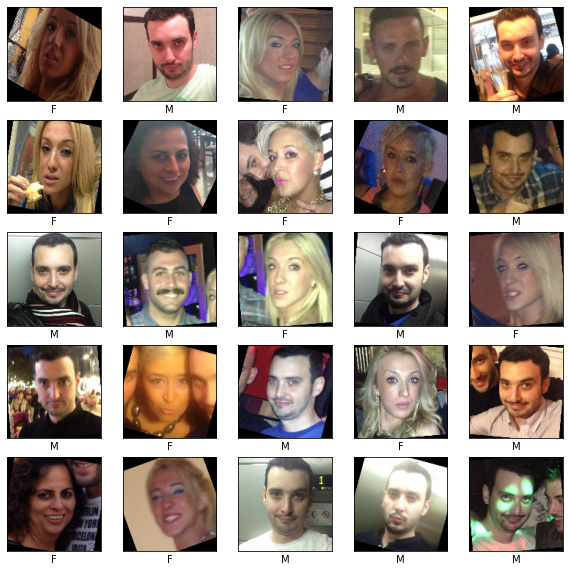

In [18]:
import cv2
## This func takes in the path (train, test or pred) and convert each image in that directory into a 32x32 numerical list that represents the embedded pixels.
## when it's for seg_pred folder, argument pred needs to be different than 0 --> different process since images in seg_pred don't have labels
##   It returns images in numerical format along with their labels
def process_data (path, pred = 0):
  X =[]
  IMG_SZ = (128, 128)
  #folder = '30601258@N03/'
  #files = glob.glob('faces/30601258@N03/*.jpg') # get a list of jpg files from each label folder 
  #print('Found {} images '.format(len(files)))
  for file in path: 
    #print(file)
    train_image = plt.imread(file[0])  # Read an image into a np array containing pixels data
    image_resized=cv2.resize(train_image, IMG_SZ) # resize an image by changing its height and width to 64x64
    X.append(image_resized)         # add the np array representing the image into X
    #Y.append(labels.index(folder))  # Add the index of an image label into Y. The index is from the Labels list
  return X


# Show 25 images and labels from given set_name
def show_sample_img(set_name, label_name, label_list):
  plt.figure(figsize=(10,10))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(set_name[i], cmap=plt.cm.binary)
      # The CIFAR labels happen to be arrays, which is why you need the extra index
      if len(label_name) != 0:
        plt.xlabel(label_list[int(label_name[i])])

  plt.show()

CLASS_NAMES = ['F', 'M']
X_imgs = process_data(X)
X_imgs
# Show 25 train img
show_sample_img(X_imgs, np.concatenate(y), label_list=CLASS_NAMES)

# **Image Pre-processing**

In [20]:
# Process train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

def preprocess_image(individual_path):
    img = tf.io.read_file(np.array(individual_path).ravel()[0]) 
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128,128])
    return img 

def yield_training_values(X_train,y_train):
    for image_path, value in zip(X_train, y_train):
        image = preprocess_image(image_path)
        yield image, value 

train = tf.data.Dataset.from_generator(yield_training_values, args=[X_train, y_train],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))
test = tf.data.Dataset.from_generator(yield_training_values, args=[X_test, y_test],
                                          output_types=(tf.float32, tf.float32),
                                          output_shapes=([128, 128, 3], [1]))

# Optimize data batching 
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE) # prefetch transformation is used to overlap the work of the producer and consumer. 

test = test.cache().shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=AUTOTUNE)

In [23]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf_device='/gpu:0'

# **Basic CNN Model**

In [24]:
## Building Basic CNN model
#tf.debugging.set_log_device_placement(True)
#gpus = tf.config.list_physical_devices('GPU')
#Model training using multiple GPUs
#strategy = tf.distribute.MirroredStrategy(gpus)
#with strategy.scope():
inputs = tf.keras.Input(shape = (128,128,3))
x = Conv2D(128, 3, activation='relu')(inputs)
x = MaxPool2D((2,2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32,(3), activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='sigmoid')(x)

gpus = tf.config.list_physical_devices('GPU')
model = tf.keras.Model(inputs, outputs)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.compile( optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')

In [ ]:
history = model.fit(train, validation_data=test,epochs=50)

Epoch 1/50
790/790 [==============================] - 216s 267ms/step - loss: 0.6874 - accuracy: 0.6015 - val_loss: 0.8528 - val_accuracy: 0.5191
Epoch 2/50
790/790 [==============================] - 39s 50ms/step - loss: 0.6121 - accuracy: 0.6671 - val_loss: 0.6085 - val_accuracy: 0.6682
Epoch 3/50
790/790 [==============================] - 39s 49ms/step - loss: 0.5414 - accuracy: 0.7263 - val_loss: 0.5061 - val_accuracy: 0.7511
Epoch 4/50
790/790 [==============================] - 38s 48ms/step - loss: 0.5099 - accuracy: 0.7442 - val_loss: 0.5878 - val_accuracy: 0.7255
Epoch 5/50
790/790 [==============================] - 38s 48ms/step - loss: 0.4701 - accuracy: 0.7728 - val_loss: 0.5032 - val_accuracy: 0.7561
Epoch 6/50
790/790 [==============================] - 38s 48ms/step - loss: 0.4374 - accuracy: 0.7926 - val_loss: 0.4890 - val_accuracy: 0.7746
Epoch 7/50
790/790 [==============================] - 38s 48ms/step - loss: 0.4036 - accuracy: 0.8173 - val_loss: 0.4646 - val_accurac

In [26]:
def plot_loss_accuracy(model, history):
  f,ax=plt.subplots(2,1,figsize=(10,10)) 

  #Assigning the first subplot to graph training loss and validation loss
  ax[0].plot(model.history.history['loss'],color='b',label='Training Loss')
  ax[0].plot(model.history.history['val_loss'],color='r',label='Validation Loss')
  plt.legend()

  #Plotting the training accuracy and validation accuracy
  ax[1].plot(model.history.history['accuracy'],color='b',label='Training  Accuracy')
  ax[1].plot(model.history.history['val_accuracy'],color='r',label='Validation Accuracy')
  plt.legend()

AttributeError: ignored

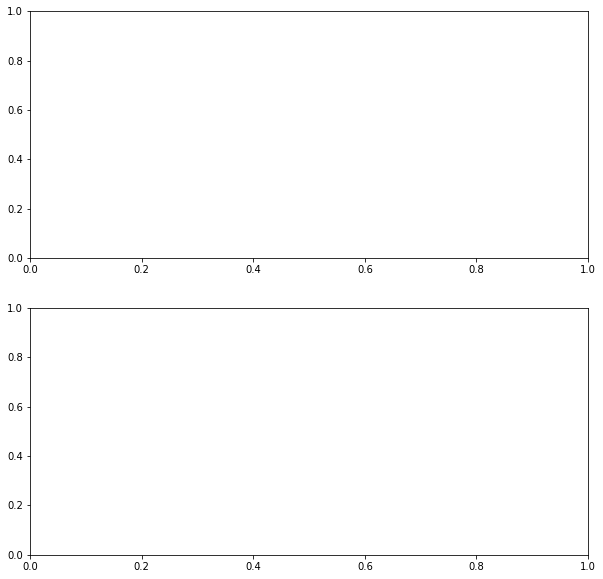

In [28]:
plot_loss_accuracy(model, history)

In [ ]:

# example of loading the vgg16 model
from keras.applications.vgg16 import VGG16 #, preprocess_input

#from tensorflow.keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Flatten, Dense
# define a new model with random weights and 10 classes
new_input = Input(shape= (128,128,3))
vgg16_pretrained = VGG16(weights=None, input_tensor=new_input, classes=2, include_top=False, pooling='avg')

## Adding fully connected layers to VGG16 to classify 6 classes
x = Flatten(name='flatten')(vgg16_pretrained.output)
x = Dense(100, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
output_layer = Dense(2, activation='softmax', name='predictions')(x)

vgg16 = Model(inputs = vgg16_pretrained.input, outputs = output_layer)

# summarize the model
vgg16.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
vgg16.compile( optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics='accuracy')
vgg16_history = vgg16.fit(train, validation_data=test,epochs=10)

Epoch 1/10
790/790 [==============================] - 94s 117ms/step - loss: 2.8685 - accuracy: 0.5559 - val_loss: 0.6858 - val_accuracy: 0.5613
Epoch 2/10
790/790 [==============================] - 93s 117ms/step - loss: 0.6863 - accuracy: 0.5594 - val_loss: 0.6861 - val_accuracy: 0.5613
Epoch 3/10
790/790 [==============================] - 92s 117ms/step - loss: 0.6862 - accuracy: 0.5598 - val_loss: 0.6857 - val_accuracy: 0.5613
Epoch 4/10
790/790 [==============================] - 92s 116ms/step - loss: 0.6862 - accuracy: 0.5598 - val_loss: 0.6856 - val_accuracy: 0.5613
Epoch 5/10
790/790 [==============================] - 92s 116ms/step - loss: 0.6862 - accuracy: 0.5598 - val_loss: 0.6857 - val_accuracy: 0.5613
Epoch 6/10
790/790 [==============================] - 91s 116ms/step - loss: 0.6862 - accuracy: 0.5598 - val_loss: 0.6857 - val_accuracy: 0.5613
Epoch 7/10
790/790 [==============================] - 91s 116ms/step - loss: 0.6862 - accuracy: 0.5598 - val_loss: 0.6858 - val_ac

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


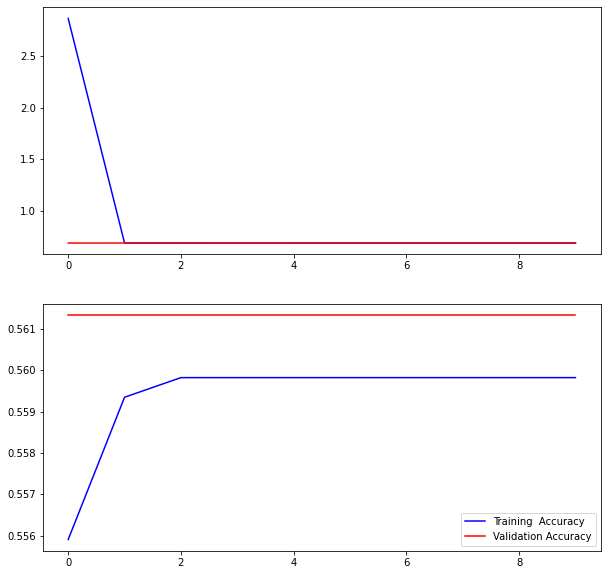

In [ ]:
plot_loss_accuracy(vgg16, vgg16_history)

In [ ]:
gpu_number = 0 #### GPU number 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_visible_devices(gpus[gpu_number], 'GPU') 
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

1 Physical GPUs, 1 Logical GPU


In [ ]:
# Create 2 virtual GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Create 2 virtual GPUs with 1GB memory each
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024),
         tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Virtual devices cannot be modified after being initialized


In [ ]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():
  inputs = tf.keras.layers.Input(shape=(1,))
  predictions = tf.keras.layers.Dense(1)(inputs)
  model = tf.keras.models.Model(inputs=inputs, outputs=predictions)
  model.compile(loss='mse',
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.2))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/50


In [ ]:
df= pd.read_csv('Data/adiencedb/AdienceBenchmarkOfUnfilteredFacesForGenderAndAgeClassification/fold_0_data.txt', sep='\t', header=0)
df

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
4479,68094148@N04,11373794746_4720ac792a_o.jpg,478,"(25, 32)",m,664,0,242,211,-5,-15,73
4480,68094148@N04,11355711315_0f5b5da125_o.jpg,477,"(25, 32)",f,915,51,109,112,0,45,14
4481,10693681@N00,9162730346_b1bf71120a_o.jpg,479,"(25, 32)",m,2145,1270,249,249,10,30,25
4482,113830953@N04,11855529986_dff116e018_o.jpg,480,None,NaN,2878,1300,306,306,-100,0,164


In [ ]:
url = 'https://raw.githubusercontent.com/pydata/pydata-book/master/ch09/stock_px.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])